# <i class="fa-solid fa-dumbbell"></i> Exercises


## Exercise 1: Model Selection
Today we are working with the `California Housing dataset`, which you are already familiar with, as we previously used it while exploring resampling method.
This dataset is based on the 1990 U.S. Census and includes features describing California districts. 

1) Familiarize yourself with the data
    - What kind of features are in the dataset? What is the target?
    - What type of problem is is the data set typically concerned with? Regression or classification?

In [1]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

2) Baseline model 
    - Create a baseline linear regression model using **all** features and evaluate the model through 5-fold cross validation, using R² as the performance metric
    - Print the individual and average R²

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Regression model
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Print the results
print("R² scores from each fold:", scores)
print("Average R² score:", np.mean(scores))

R² scores from each fold: [0.54866323 0.46820691 0.55078434 0.53698703 0.66051406]
Average R² score: 0.5530311140279571


3) Apply a forward stepwise selection to find a simpler suitable model.
    - Split the data into 80% training data and 20% testing data (print the shape to confirm it was sucessful)
    - Perform a forward stepwise selection with a linear regression model, 5-fold CV, R² score, and `parsimonious` feature selection (refer to the documentation for further information)
    - Print the best CV R² as well as the chosen features

In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Forward Sequential Feature Selector
sfs_forward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    k_features="parsimonious",
    forward=True,
    floating=False,
    scoring='r2',
    cv=5,
    verbose=0)

sfs_forward.fit(X_train, y_train)

print(f">> Forward SFS:")
print(f"   Best CV R²      : {sfs_forward.k_score_:.3f}")
print(f"   Optimal # feats : {len(sfs_forward.k_feature_idx_)}")
print(f"   Feature names   : {sfs_forward.k_feature_names_}")

(16512, 8) (4128, 8)
(16512,) (4128,)
>> Forward SFS:
   Best CV R²      : 0.612
   Optimal # feats : 7
   Feature names   : ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude')


3) Evaluate the model on the test set

In [4]:
selected_features = list(sfs_forward.k_feature_names_)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train and evaluate
model.fit(X_train_selected, y_train)
test_r2 = model.score(X_test_selected, y_test)
print(f"Test R² for the sfs model: {test_r2:.4f}")

Test R² for the sfs model: 0.5757


## Exercise 2: LASSO

Please implement a Lasso regression model similar to the Ridge model in the [Regularization](2_Regularization) section.

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Data related processing
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data
hitters_subset = hitters[["Salary", "AtBat", "Runs","RBI", "CHits", "CAtBat", "CRuns", "CWalks", "Assists", "Hits", "HmRun", "Years", "Errors", "Walks"]].copy()
hitters_subset = hitters_subset.drop(columns=["CRuns", "CAtBat"]) # Remove highly correlated features (see previous session)
hitters_subset.dropna(inplace=True) # drop rows containing missing data

y = hitters_subset["Salary"]
X = hitters_subset.drop(columns=["Salary"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler() # Scale predictors to mean=0 and std=1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# TODO: Implement Lasso 
lambda_range = np.linspace(0.001, 20, 100) 

# Get the optimal lambda
lasso_cv = LassoCV(alphas=lambda_range)
lasso_cv.fit(X_train_scaled, y_train) 

print(f"Optimal alpha: {lasso_cv.alpha_}\n")

# Get training R²
train_score_ridge= lasso_cv.score(X_train_scaled, y_train)
print(f"Training R²: {train_score_ridge}\n")

# Put the coefficients into a nicely formatted df for visualization
coef_table = pd.DataFrame({
    'Predictor': X_train.columns,
    'Beta': lasso_cv.coef_
})

coef_table = coef_table.reindex(coef_table['Beta'].abs().sort_values(ascending=False).index)
print(coef_table, "\n")


test_score_ridge= lasso_cv.score(X_test_scaled, y_test)
print(f"Test R²: {test_score_ridge}")

Optimal alpha: 20.0

Training R²: 0.47908195299121104

   Predictor        Beta
3      CHits  177.984173
6       Hits  101.982447
7      HmRun   52.177420
10     Walks   41.664953
2        RBI    0.000000
0      AtBat    0.000000
1       Runs    0.000000
5    Assists   -0.000000
4     CWalks    0.000000
8      Years    0.000000
9     Errors   -0.000000 

Test R²: 0.31479649243077035


## Exercise 3: GAM
The dataset we are using for the exercise is the [Diabetes Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), which you already know from the theoretical part of the seminar. 

It contains: 
- 10 baseline features measured at the beginning of the study:
    - age, sex, Body Mass Index (BMI), average blood pressure, six blood serum measurements (e.g. cholesterol, blood sugar, etc.)
- Target variable: A quantitative measure of disease progression one year after the baseline measurements were taken.

Let's prepare the data for further analysis.

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# load data
diabetes = datasets.load_diabetes(as_frame=True)

# TODO: define feature and target
X= diabetes.data
y= diabetes.target

# TODO: split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Let`s also again plot the target and features to see which model may describe the relationship the best.

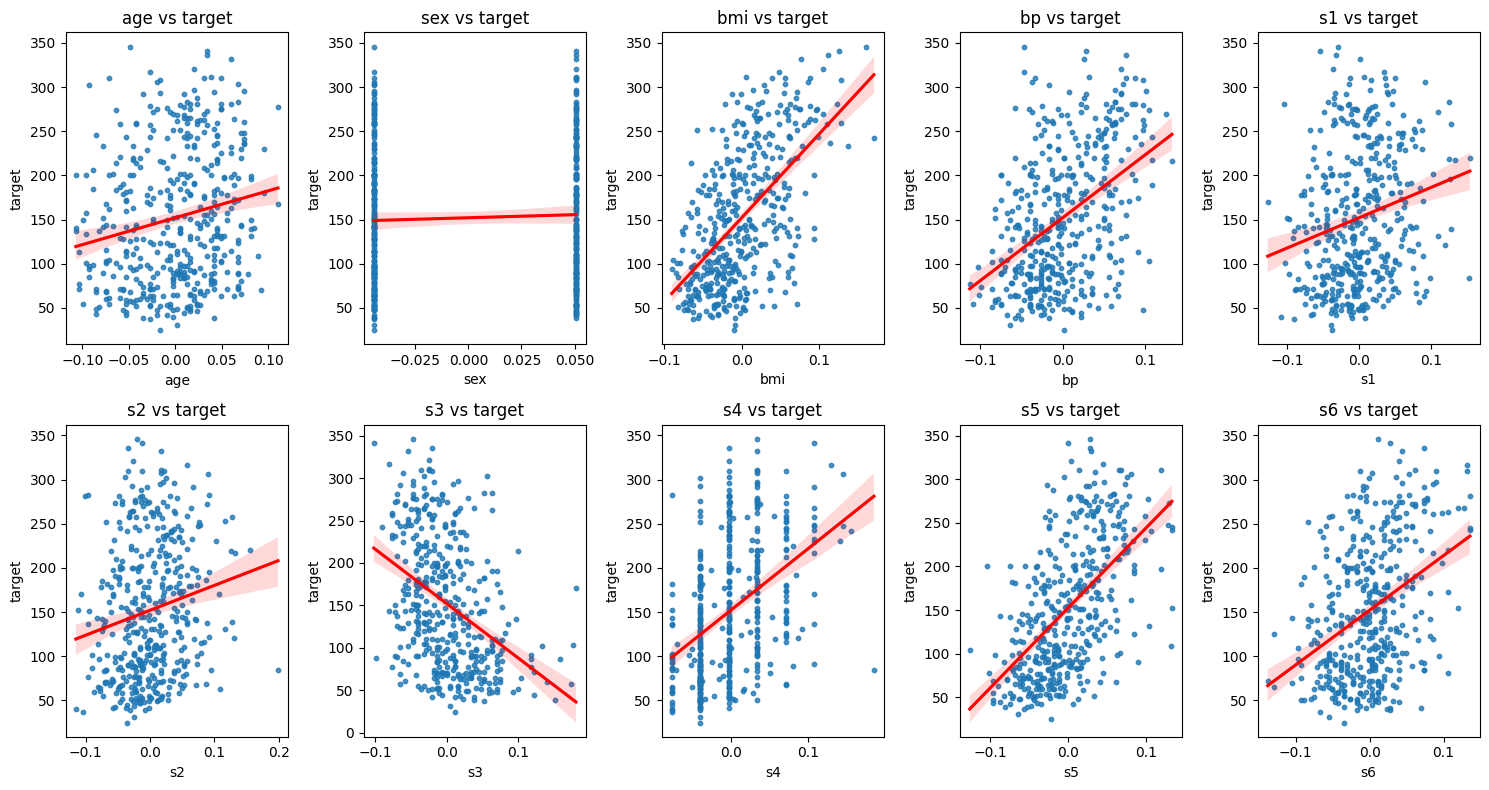

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Combine into a single DataFrame for easy plotting
df = X.copy()
df['target'] = y
features_to_plot = X.columns
# Set up the plot grid
num_features = len(features_to_plot)
cols = 5
rows = (num_features + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()
# Plot each feature (except 'sex') against the target
for i, col in enumerate(features_to_plot):
    sns.regplot(x=col, y='target', data=df, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f"{col} vs target")
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In the session, we noticed that the model we fitted did not perform well on our data — even a simple linear model yielded better results.

1. Your task is to improve the model's performance on unseen data. Use the feature-target plots to determine the most appropriate modeling approach (linear, smooth, or categorical) for each feature. Select the type of model based on the relationship observed in these plots. Remember, that you could also adjust the degrees of freedom.

    Can you build a model that outperforms the simple linear model, which achieved an R² of 0.48? Or is the linear model the best fit for our data?

In [7]:
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# combine into one  datafra,e
train_data= X_train.copy()
train_data["target"]= y_train

test_data = X_test.copy()
test_data["target"] = y_test


# TODO: define formula
formula = (
    "bs(age, df=6) + "           
    "C(sex) + "                 
    "bs(bmi, df=6)+ "
    "bs(bp, df=3) + "
    "bs(s1, df=6) + "
    "bs(s2, df=6) + "
    "bs(s3, df=6) + "
    "bs(s4, df=6) + "
    "s5 + "                      
    "bs(s6, df=6)"              
)


# TODO: Build design matrix from training data
X_train_design = dmatrix(formula, data=train_data, return_type="dataframe")
X_test_design = dmatrix(formula, data=test_data, return_type="dataframe")

#Fit model
model = LinearRegression()
model.fit(X_train_design, y_train)

# Predictions & Evaluation
y_pred = model.predict(X_test_design)
r2 = r2_score(y_test, y_pred)
print(f"R² on test data: {r2:.3f}")

R² on test data: 0.444


## Exercise 4: GAM 
In this exercise, we’ll continue exploring Generalized Additive Models (GAMs).
Our new dataset - the [wage](https://islp.readthedocs.io/en/latest/datasets/Wage.html) dataset - contains information on **wage income** for a group of workers, along with demographic and employment-related features such as age, education, marital status, and job class. Unlike our earlier examples, this dataset includes a mix of numeric and categorical variables, and the categorical variables are **not dummy-coded** — they are stored as strings or categories.


1) Explore the dataset
    - Which variables are numeric?
    - Which ones are categorical?

In [8]:
from ISLP import load_data
import pandas as pd

# Load Wage dataset
Wage = load_data('Wage')

# Define X and y
X = Wage[["age", "jobclass", "race", "education", "year"]]  # In this case we are only using 5 features
y = Wage['wage']                                            # Target

# TODO: Explore the features.
print(X.head())

   age        jobclass      race        education  year
0   18   1. Industrial  1. White     1. < HS Grad  2006
1   24  2. Information  1. White  4. College Grad  2004
2   45   1. Industrial  1. White  3. Some College  2003
3   43  2. Information  3. Asian  4. College Grad  2003
4   50  2. Information  1. White       2. HS Grad  2005


2) Plot the features against the target variable *wage*. Focus especially on features where you're not sure whether the relationship is linear or nonlinear. You do not need to plot categorical variables.

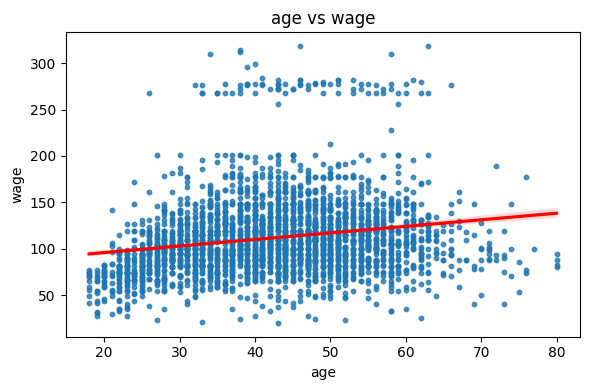

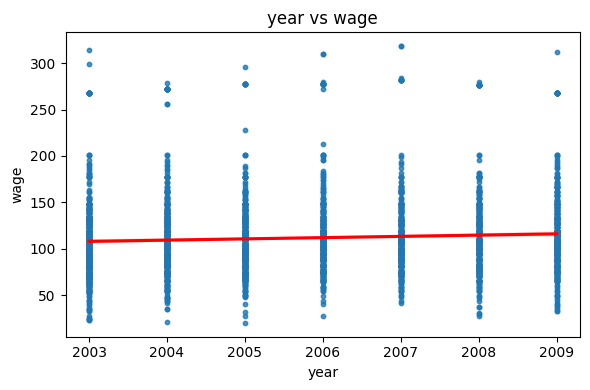

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Plot the feature 
# Combine X and y for plotting
data = X.copy()
data['wage'] = y

# Define only the features you want to plot
features_to_plot = ['age', 'year']

# Plot each selected feature
for col in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=col, y='wage', data=data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.title(f"{col} vs wage")
    plt.tight_layout()
    plt.show()



3) Fit a Generalized Additive Model (GAM)

In [10]:
from patsy import dmatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# TODO: Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# TODO: Combine into one dataframe
train_data = X_train.copy()
train_data["target"] = y_train

test_data = X_test.copy()
test_data["target"] = y_test

#  TODO: Generate formula
formula = (
    "bs(age, df=6) + "            # smooth
    "bs(year, df=6) + "           # smooth
    "C(race) + "                  # categorical
    "C(education) + "             # categorical
    "C(jobclass)"                 # categorical
)

# TODO: Design Matrix
X_train_design = dmatrix(formula, data=train_data, return_type="dataframe")
X_test_design = dmatrix(formula, data=test_data, return_type="dataframe")

# TODO: Fit the model
model = LinearRegression()
model.fit(X_train_design, y_train)

LinearRegression()

4) Evaluate model performance

In [11]:
# TODO: Predictions & Evaluation 
y_pred = model.predict(X_test_design)
r2 = r2_score(y_test, y_pred)


print(f"R² on test data: {r2:.3f}")

R² on test data: 0.290


AN MICHA: Warum performen die models immer so schlecht?! 

## Exercise 5: KNN
For this exercise we are using the **Wine** dataset from `sklearn.datasets`. It is a classic classification dataset containing the chemical analysis of wines grown in the same region of Italy but derived from three different cultivars (wine classes). Let's have a look at the data.

In [12]:
from sklearn.datasets import load_wine
data = load_wine(as_frame=True)
X = data.data
y = data.target

#print(X)
print(X.dtypes)

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object


The dataset contains 13 features in total. To simplify our task and better visualize the classification process, let's select only **two features** and use them to build a K-Nearest Neighbors (KNN) classifier.


1) Choose any two features from the dataset and assign them to a new variable X. Keep in mind that using only two out of thirteen features means we’re working with just 15% of the available information — so while the model will be easy to interpret and plot, it likely won’t achieve the best possible performance!

In [13]:
# TODO- Choose 2 features and define them to your new X!
# X= X[["alcohol", "flavanoids"]]
X= X[["alcohol", "magnesium"]]

2) Visualize the chosen features with a scatterplot

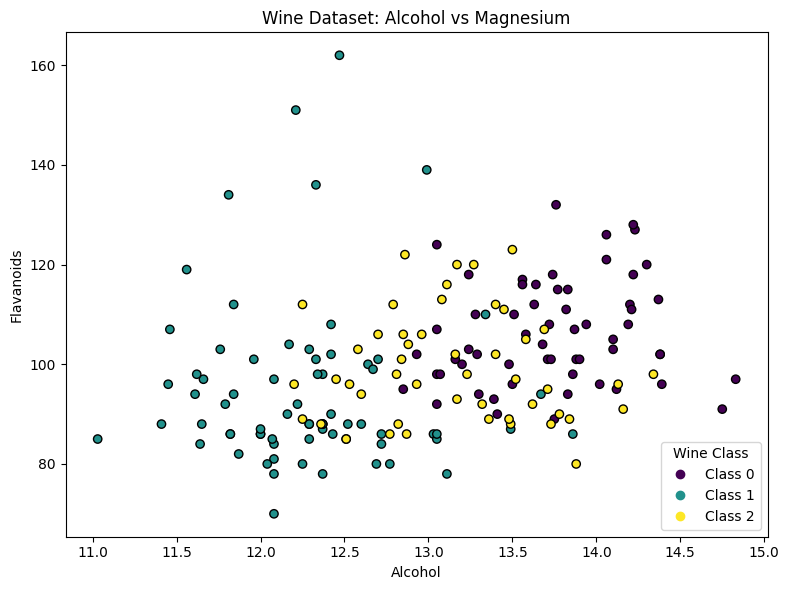

In [14]:
import matplotlib.pyplot as plt


# TODO: Complete the code to get a scatterplot showing your 2 features
# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X['alcohol'], X['magnesium'], c=y, cmap='viridis', edgecolor='k'
)

# Axis labels and title
plt.xlabel("Alcohol")
plt.ylabel("Flavanoids")
plt.title("Wine Dataset: Alcohol vs Magnesium")

# Add legend
classes = list(set(y))
handles = scatter.legend_elements()[0]
labels = [f"Class {c}" for c in classes]
plt.legend(handles=handles, labels=labels, title="Wine Class", loc="lower right")

plt.tight_layout()
plt.show()


Take a moment to explore the data you’ve just visualized. Does it appear to be clearly separated into distinct classes, like the famous Iris dataset? Or is there a lot of overlap between the groups? 

Based on what you see, make a guess: 
- Do you expect that a high or low value of k will work best for KNN in this case? 
- And given that you’re only using two features, do you think the model will achieve high accuracy, or might performance suffer because of limited information?

3) Split the data set using `train_test_split` and standardize it. Do you remember, which one to do first?


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TODO: Split the data into test and trainings data set and standardize
# Tip: Use strtify=y in train_test_split to  ensures that all classes are represented proportionally in both 
# the training and test sets — which is especially important in multiclass classification like the Wine dataset.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

4) Identify the best k for your data

Text(0, 0.5, 'Accuracy Score')

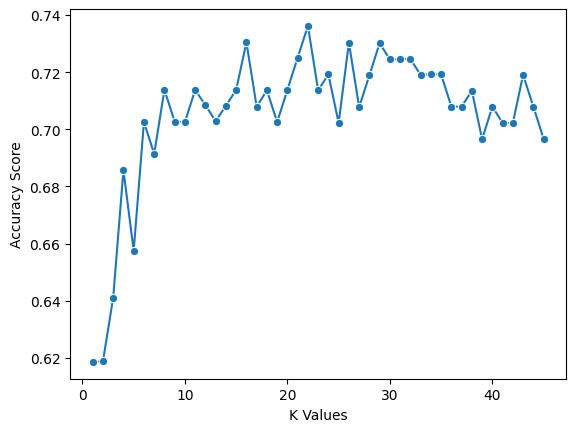

In [16]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Choose a range for k
k_range= list(range(1, 46))


# variable to store the accuracy scores in loop
scores= []

# loop trough the range of k using cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_scaled, y, cv=5)      # get scores for each k
    scores.append(np.mean(score))                 # append mean score to list

# TODO: plot accurcay angainst the range of k
sns.lineplot(x = k_range, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [17]:
#TODO: Identify the best k
best_index = np.argmax(scores)
# getting best k
best_k = k_range[best_index]
# getting accuracy of best k
best_score = scores[best_index]

print(f"Best k: {best_k}")
print(f"Accuracy with best k: {best_score:.4f}")

Best k: 22
Accuracy with best k: 0.7362


5) Finally train the model using the best k and evalute the model performane on unseen data.

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# TODO:  Train the model using training data
knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(X_train, y_train)

#The model is now trained using the training data. Next, we can use it to make predictions on the test set. 

# predict the feature-category with the trained model
y_pred = knn.predict(X_test)

# TODO: check accuracy
accuracy_score(y_test, y_pred)


0.46296296296296297